<a href="https://www.kaggle.com/code/filevault/notebook2311a9991e?scriptVersionId=277980079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/economics-fraud-detection-financial-inclusion/sample_submission.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/bureau_balance.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/POS_CASH_balance.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/application_train.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/HomeCredit_columns_description.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/application_test.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/previous_application.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/credit_card_balance.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/installments_payments.csv
/kaggle/input/economics-fraud-detection-financial-inclusion/bureau.csv


In [4]:
!pip install lightgbm==3.3.5 shap fairlearn scikit-learn==1.2.2 category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0


In [5]:
import os, gc, sys, math, time, random
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

# Optional fairness libs
try:
    from fairlearn.postprocessing import ThresholdOptimizer
    from fairlearn.metrics import MetricFrame, false_positive_rate
    FAIRLEARN_AVAILABLE = True
except Exception:
    FAIRLEARN_AVAILABLE = False

RND = 42
np.random.seed(RND)
random.seed(RND)


In [6]:
# -------------------------
# Configuration
# -------------------------
DATA_DIR = '/kaggle/input/economics-fraud-detection-financial-inclusion'  # change if needed
OUT_DIR = '/kaggle/working'
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

TARGET = 'TARGET'
GLOBAL_THRESHOLD = 0.114  # paper baseline

# LightGBM parameters for GPU (works when GPU available; otherwise falls back)
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'min_data_in_leaf': 20,
    'max_bin': 255,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': -1,
    'seed': RND,
    # GPU device: uncomment if you want to force specific device ids
    'device': 'gpu',        # will use GPU if LightGBM built with GPU
    # 'gpu_platform_id': 0,
    # 'gpu_device_id': 0
}

# Training config
N_SPLITS = 5
N_ESTIMATORS = 10000
EARLY_STOPPING_ROUNDS = 150
NUM_BOOST_ROUND = 5000  # safety upper bound

# -------------------------
# Utility functions
# -------------------------
def safe_read(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return pd.read_csv(path)

def print_mem(msg=''):
    import psutil
    print(msg, "Mem (GB):", round(psutil.Process().memory_info().rss/1024**3,3))

# -------------------------
# 0) Check GPU availability (LightGBM)
# -------------------------
def lgb_gpu_available():
    try:
        # attempt to create a small gpu dataset
        tmp = lgb.Dataset(np.random.rand(10,4), label=np.random.randint(0,2,10))
        booster = lgb.train({**lgb_params, 'verbose': -1}, tmp, num_boost_round=1)
        return ('gpu' in booster.params.get('device', '').lower()) or ('gpu' in booster.params.get('device_type','').lower())
    except Exception as e:
        return False

GPU = lgb_gpu_available()
print("LightGBM GPU available:", GPU)
if not GPU:
    # fallback to CPU
    lgb_params.pop('device', None)


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
LightGBM GPU available: False


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1


In [7]:
# -------------------------
# 1) Load main file (fragmentation-free pipeline)
# -------------------------
app = safe_read(os.path.join(DATA_DIR, 'application_train.csv'))
print("Application loaded:", app.shape)

# Load small secondary files for simple aggregated features (you can add more)
prev = safe_read(os.path.join(DATA_DIR, 'previous_application.csv'))
inst = safe_read(os.path.join(DATA_DIR, 'installments_payments.csv'))


Application loaded: (307511, 122)


In [8]:
# -------------------------
# 2) Aggregations (do them in separate frames, then concat once)
# -------------------------
def agg_numeric(df, by='SK_ID_CURR', prefix='AGG'):
    num = df.select_dtypes(include=[np.number]).copy()
    if by not in num.columns:
        num[by] = df[by]
    agg = num.groupby(by).agg(['mean','sum','min','max','std'])
    # flatten columns
    agg.columns = [f"{prefix}_{c}_{stat}" for c, stat in agg.columns]
    agg.reset_index(inplace=True)
    return agg

print("Aggregating prev and inst tables...")
agg_prev = agg_numeric(prev, by='SK_ID_CURR', prefix='PA')
agg_inst = agg_numeric(inst, by='SK_ID_CURR', prefix='INST')



Aggregating prev and inst tables...


In [9]:
# -------------------------
# 3) Build feature matrix in one concat (avoid fragmentation)
# -------------------------
print("Merging and building features (single concatenation)...")
app_small = app.copy()  # keep original intact

# engineered features frame
eng = pd.DataFrame()
eng['SK_ID_CURR'] = app_small['SK_ID_CURR']
# simple ratios & transforms
eng['CREDIT_TO_INCOME'] = app_small['AMT_CREDIT'] / (1 + app_small['AMT_INCOME_TOTAL'])
eng['ANNUITY_TO_INCOME'] = app_small['AMT_ANNUITY'] / (1 + app_small['AMT_INCOME_TOTAL'])
eng['LOG_AMT_INCOME_TOTAL'] = np.log1p(app_small['AMT_INCOME_TOTAL'])

# categorical columns we will keep as LightGBM categories (no one-hot)
cats = ['CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']
cats = [c for c in cats if c in app_small.columns]

# numeric block (select numeric cols except TARGET)
num_cols = app_small.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in [TARGET,'SK_ID_CURR']]

numeric_block = app_small[['SK_ID_CURR'] + num_cols].copy()

# merge blocks by SK_ID_CURR (single concat)
df_merged = numeric_block.merge(eng, on='SK_ID_CURR', how='left').merge(agg_prev, on='SK_ID_CURR', how='left').merge(agg_inst, on='SK_ID_CURR', how='left')

# attach categorical columns (as-is; LightGBM handles them if indices/types are categorical)
for c in cats:
    df_merged[c] = app_small[c].astype('category')

# final label
df_merged[TARGET] = app_small[TARGET].values

# De-fragment the frame: copy to ensure contiguous memory blocks
df_merged = df_merged.copy()
print("Final DF shape:", df_merged.shape)


Merging and building features (single concatenation)...
Final DF shape: (307511, 251)


In [10]:
# -------------------------
# 4) Train/hold split and feature list
# -------------------------
# Reserve holdout for final audit/optimizations
train_df, hold_df = train_test_split(df_merged, test_size=0.20, stratify=df_merged[TARGET], random_state=RND)
print("Train / Hold shapes:", train_df.shape, hold_df.shape)

# Features: all except SK_ID_CURR and TARGET
features = [c for c in train_df.columns if c not in ['SK_ID_CURR', TARGET]]
# identify categorical features by name
cat_features = [c for c in features if str(train_df[c].dtype) == 'category']

print("Num features:", len(features), "Categorical features:", cat_features)

# prepare arrays
X_full = train_df[features]
y_full = train_df[TARGET].values
X_hold = hold_df[features]
y_hold = hold_df[TARGET].values

Train / Hold shapes: (246008, 251) (61503, 251)
Num features: 249 Categorical features: ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [11]:
# -------------------------
# 5) K-Fold LightGBM training with callbacks (GPU-friendly)
# -------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RND)
oof = np.zeros(X_full.shape[0])
hold_preds = np.zeros(X_hold.shape[0])
models = []
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = features

print("Starting CV training... GPU:", GPU)
fold = 0
for train_idx, val_idx in skf.split(X_full, y_full):
    fold += 1
    X_tr, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_val = y_full[train_idx], y_full[val_idx]
    dtrain = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_features, free_raw_data=False)
    dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=dtrain, free_raw_data=False)

    # Use callbacks instead of deprecated args
    callbacks = [
        lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False),
        lgb.log_evaluation(period=0)  # quiet training logs; set to period=100 to see logs
    ]
    # train
    model = lgb.train(
        params={**lgb_params, 'metric':'auc'}, 
        train_set=dtrain, 
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[dtrain, dval],
        valid_names=['train','valid'],
        callbacks=callbacks
    )
    models.append(model)
    best_iter = model.best_iteration or model.params.get('num_iteration', NUM_BOOST_ROUND)
    # predict oof and hold
    oof[val_idx] = model.predict(X_val, num_iteration=best_iter)
    hold_preds += model.predict(X_hold, num_iteration=best_iter) / N_SPLITS

    # feature importance
    fi = model.feature_importance(importance_type='gain')
    feature_importance_df[f'fold_{fold}'] = fi

    print(f"Fold {fold} done. Best iter: {best_iter}")

Starting CV training... GPU: False


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Fold 1 done. Best iter: 207


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Fold 2 done. Best iter: 261


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Fold 3 done. Best iter: 158


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Fold 4 done. Best iter: 197


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Fold 5 done. Best iter: 309


CV ROC-AUC: 0.7714461141409397
Holdout ROC: 0.7779046911457068 Holdout AUPRC: 0.2705856264631502


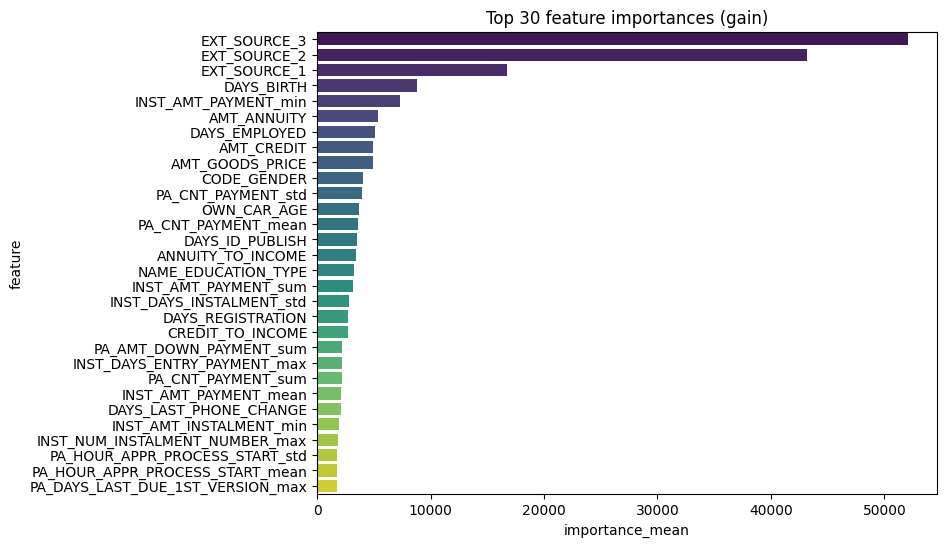

In [12]:
# CV metrics
cv_auc = roc_auc_score(y_full, oof)
print("CV ROC-AUC:", cv_auc)
precision, recall, _ = precision_recall_curve(y_hold, hold_preds)
hold_auprc = auc(recall, precision)
hold_roc = roc_auc_score(y_hold, hold_preds)
print("Holdout ROC:", hold_roc, "Holdout AUPRC:", hold_auprc)

# aggregate feature importance
feature_importance_df['importance_mean'] = feature_importance_df[[c for c in feature_importance_df.columns if c.startswith('fold_')]].mean(axis=1)
fi_sorted = feature_importance_df.sort_values('importance_mean', ascending=False).head(30)
plt.figure(figsize=(8,6))
sns.barplot(x='importance_mean', y='feature', data=fi_sorted, palette='viridis')
plt.title('Top 30 feature importances (gain)')
plt.show()

# Save models & artifacts
joblib.dump(models, os.path.join(OUT_DIR, 'lgbm_cv_models.pkl'))
feature_importance_df.to_csv(os.path.join(OUT_DIR, 'feature_importances.csv'), index=False)


Computing SHAP (sampled)...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


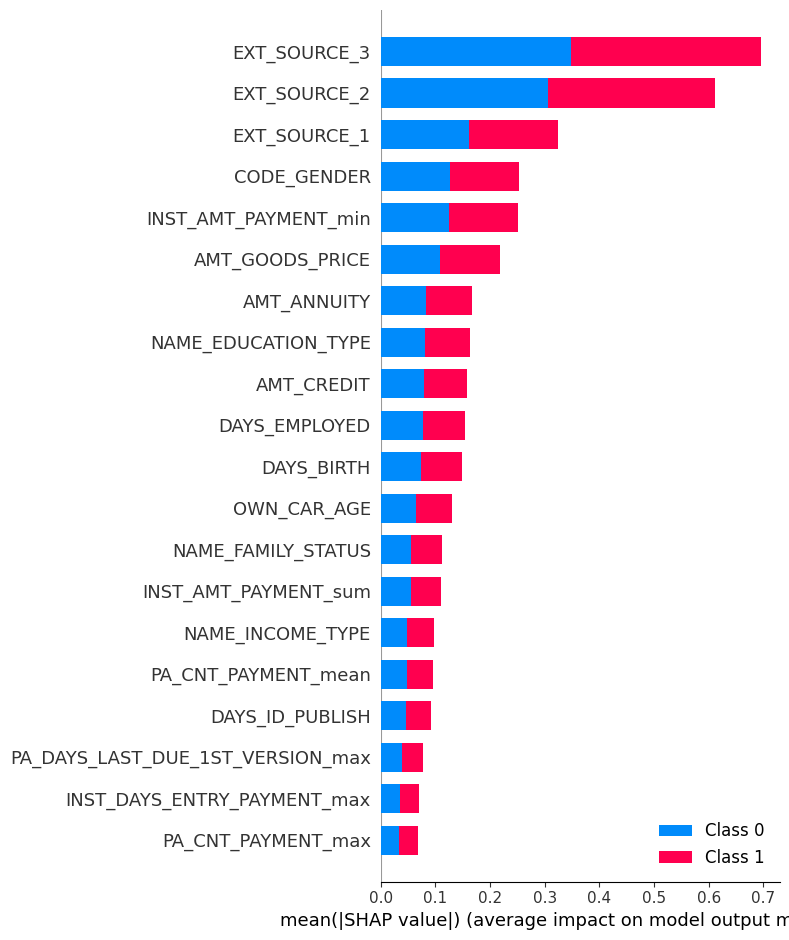

                 feature  mean_abs_shap
0           CNT_CHILDREN       0.001368
1       AMT_INCOME_TOTAL       0.007232
2             AMT_CREDIT       0.078915
3            AMT_ANNUITY       0.083564
4        AMT_GOODS_PRICE       0.109019
..                   ...            ...
244  NAME_EDUCATION_TYPE       0.081663
245   NAME_FAMILY_STATUS       0.055885
246    NAME_HOUSING_TYPE       0.004825
247         FLAG_OWN_CAR       0.001902
248      FLAG_OWN_REALTY       0.001345

[249 rows x 2 columns]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [13]:
# -------------------------
# 6) SHAP explainability (sampled to save time)
# -------------------------
print("Computing SHAP (sampled)...")
explainer = shap.TreeExplainer(models[-1], feature_perturbation="tree_path_dependent")
sample_idx = np.random.choice(X_hold.shape[0], size=min(4000, X_hold.shape[0]), replace=False)
X_sample = X_hold.iloc[sample_idx]
shap_values = explainer.shap_values(X_sample)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False, max_display=20)
plt.tight_layout()
plt.show()

# mean absolute shap table (top 20)
shap_values = explainer.shap_values(X_sample)

# For binary classification shap_values is a list -> use class 1
shap_val = shap_values[1]  # shape = (n_samples, n_features)

mean_abs_shap = np.abs(shap_val).mean(axis=0)

shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
})

print(shap_df)


In [14]:
# -------------------------
# 7) Fairness audit on holdout (group FPR)
# -------------------------
print("Running fairness audit on holdout with baseline threshold:", GLOBAL_THRESHOLD)
hold_df_local = X_hold.copy()
hold_df_local['y_true'] = y_hold
hold_df_local['score'] = hold_preds
# attach group labels from hold_df (we preserved the categorical columns)
for g in ['NAME_INCOME_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']:
    if g in hold_df.columns:
        hold_df_local[g] = hold_df[g].values
    else:
        hold_df_local[g] = 'MISSING'

def compute_group_fpr(df, group_col, threshold=GLOBAL_THRESHOLD):
    rows=[]
    for g, sub in df.groupby(group_col):
        preds = (sub['score'] >= threshold).astype(int)
        tn = ((sub['y_true']==0) & (preds==0)).sum()
        fp = ((sub['y_true']==0) & (preds==1)).sum()
        fn = ((sub['y_true']==1) & (preds==0)).sum()
        tp = ((sub['y_true']==1) & (preds==1)).sum()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        rows.append({'group': g, 'count': len(sub), 'fpr': fpr, 'tp':tp,'tn':tn,'fp':fp,'fn':fn})
    return pd.DataFrame(rows).sort_values('fpr', ascending=False).reset_index(drop=True)

inc_fpr_df = compute_group_fpr(hold_df_local, 'NAME_INCOME_TYPE', threshold=GLOBAL_THRESHOLD)
gender_fpr_df = compute_group_fpr(hold_df_local, 'CODE_GENDER', threshold=GLOBAL_THRESHOLD)
print("NAME_INCOME_TYPE FPR:")
print(inc_fpr_df)
print("CODE_GENDER FPR:")
print(gender_fpr_df)


Running fairness audit on holdout with baseline threshold: 0.114
NAME_INCOME_TYPE FPR:
                  group  count       fpr    tp     tn    fp    fn
0            Unemployed      5  0.500000     2      1     1     1
1               Student      7  0.285714     0      5     2     0
2               Working  31731  0.220751  1907  22306  6319  1199
3  Commercial associate  14344  0.157891   512  11227  2105   500
4         State servant   4185  0.115657   112   3502   458   113
5             Pensioner  11228  0.077561   220   9788   823   397
6           Businessman      1  0.000000     0      1     0     0
7       Maternity leave      2       NaN     2      0     0     0
CODE_GENDER FPR:
  group  count       fpr    tp     tn    fp    fn
0   XNA      2  0.500000     0      1     1     0
1     M  20940  0.238903  1339  14317  4494   790
2     F  40561  0.138184  1416  32512  5213  1420


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


In [16]:
# -------------------------
# 8) Optimization: coordinate-descent Pareto for per-group thresholds
#    Efficient vectorized approach using numpy (fast)
# -------------------------
print("Running Pareto threshold optimization (coordinate descent)...")

def group_metrics_for_thresholds_array(y_true_arr, score_arr, group_arr, unique_groups, thresholds_map):
    """
    Vectorized-ish computation that returns:
      - recall (global)
      - disp_range (max FPR - min FPR)
      - disp_std
      - per_group: dict[group] -> {'count', 'fpr', 'tp','tn','fp','fn'}
    """
    # build a small dataframe for readable grouping (ok for holdout size)
    df = pd.DataFrame({'y': y_true_arr, 's': score_arr, 'g': group_arr})
    per_group = {}
    tp = fn = fp = tn = 0
    for g in unique_groups:
        sub = df[df['g'] == g]
        t = thresholds_map[g]
        preds = (sub['s'] >= t).astype(int)
        tn_g = int(((sub['y'] == 0) & (preds == 0)).sum())
        fp_g = int(((sub['y'] == 0) & (preds == 1)).sum())
        fn_g = int(((sub['y'] == 1) & (preds == 0)).sum())
        tp_g = int(((sub['y'] == 1) & (preds == 1)).sum())
        count_g = len(sub)
        fpr_g = fp_g / (fp_g + tn_g) if (fp_g + tn_g) > 0 else 0.0
        per_group[g] = {
            'count': count_g,
            'fpr': fpr_g,
            'tp': tp_g,
            'tn': tn_g,
            'fp': fp_g,
            'fn': fn_g
        }
        tp += tp_g; fn += fn_g; fp += fp_g; tn += tn_g

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr_vals = np.array([v['fpr'] for v in per_group.values()])
    disp_range = float(np.max(fpr_vals) - np.min(fpr_vals))
    disp_std = float(np.std(fpr_vals))
    return recall, disp_range, disp_std, per_group


def pareto_coordinate_descent(df_scores, group_col='NAME_INCOME_TYPE', base_threshold=GLOBAL_THRESHOLD, steps=51, max_iter=8):
    unique_groups = sorted(df_scores[group_col].unique())
    grid = np.linspace(0.0, 1.0, steps)
    thresholds = {g: base_threshold for g in unique_groups}
    history = []
    for it in range(max_iter):
        changed = False
        for g in unique_groups:
            best_local = None
            for t in grid:
                thr = thresholds.copy(); thr[g] = float(t)
                recall, disp_range, disp_std, per = group_metrics_for_thresholds_array(
                    df_scores['y_true'].values, df_scores['score'].values, df_scores[group_col].values, unique_groups, thr
                )
                obj = disp_range + 0.1 * max(0, 0.427 - recall)  # soft penalty
                if (best_local is None) or (obj < best_local[0]):
                    best_local = (obj, t, recall, disp_range, disp_std)
            if thresholds[g] != best_local[1]:
                thresholds[g] = float(best_local[1])
                changed = True
        recall, disp_range, disp_std, per = group_metrics_for_thresholds_array(
            df_scores['y_true'].values, df_scores['score'].values, df_scores[group_col].values, unique_groups, thresholds
        )
        history.append({'iter': it, 'recall': recall, 'disp_range': disp_range, 'disp_std': disp_std, 'thresholds': thresholds.copy()})
        if not changed:
            break
    return thresholds, history


# Prepare small DataFrame for optimization (NAME_INCOME_TYPE)
opt_df = hold_df_local[['y_true','score','NAME_INCOME_TYPE']].rename(columns={'NAME_INCOME_TYPE':'group'}).copy()
opt_df = opt_df.rename(columns={'group':'NAME_INCOME_TYPE'})
opt_df = opt_df.rename(columns={'NAME_INCOME_TYPE':'group'})  # keep name 'group' in function call

# Run optimization (this can take a minute or two)
recommended_thresholds, history = pareto_coordinate_descent(opt_df.rename(columns={'group':'NAME_INCOME_TYPE'}), group_col='NAME_INCOME_TYPE', steps=41, max_iter=6)
print("Recommended thresholds (NAME_INCOME_TYPE):")
for g,t in recommended_thresholds.items():
    print(g, round(t,3))

# Evaluate recommended configuration
recall_after, disp_after, std_after, per_after = group_metrics_for_thresholds_array(opt_df['y_true'].values, opt_df['score'].values, opt_df['group'].values, sorted(opt_df['group'].unique()), recommended_thresholds)
recall_before, disp_before, std_before, per_before = group_metrics_for_thresholds_array(opt_df['y_true'].values, opt_df['score'].values, opt_df['group'].values, sorted(opt_df['group'].unique()), {g:GLOBAL_THRESHOLD for g in sorted(opt_df['group'].unique())})
print(f"Recall before: {recall_before:.4f}, disparity before: {disp_before:.4f}")
print(f"Recall after: {recall_after:.4f}, disparity after: {disp_after:.4f}")

# Build summary table for paper
# Evaluate recommended configuration
unique_groups = sorted(opt_df['group'].unique())
recall_after, disp_after, std_after, per_after = group_metrics_for_thresholds_array(
    opt_df['y_true'].values, opt_df['score'].values, opt_df['group'].values, unique_groups, recommended_thresholds
)
recall_before, disp_before, std_before, per_before = group_metrics_for_thresholds_array(
    opt_df['y_true'].values, opt_df['score'].values, opt_df['group'].values, unique_groups, {g: GLOBAL_THRESHOLD for g in unique_groups}
)

print(f"Recall before: {recall_before:.4f}, disparity before: {disp_before:.4f}")
print(f"Recall after: {recall_after:.4f}, disparity after: {disp_after:.4f}")

# Build summary table for paper
summary_rows = []
for g in unique_groups:
    row_b = per_before[g]
    row_a = per_after[g]
    summary_rows.append({
        'group': g,
        'count': row_b['count'],
        'fpr_before': row_b['fpr'],
        'fpr_after': row_a['fpr'],
        'threshold_before': GLOBAL_THRESHOLD,
        'threshold_after': recommended_thresholds[g]
    })
summary_df = pd.DataFrame(summary_rows).sort_values('fpr_before', ascending=False)
print(summary_df.head(20))
summary_df.to_csv(os.path.join(OUT_DIR, 'income_thresholds_summary.csv'), index=False)


Running Pareto threshold optimization (coordinate descent)...
Recommended thresholds (NAME_INCOME_TYPE):
Businessman 0.025
Commercial associate 0.1
Maternity leave 0.0
Pensioner 0.075
State servant 0.1
Student 0.175
Unemployed 0.25
Working 0.15
Recall before: 0.5549, disparity before: 0.5000
Recall after: 0.5210, disparity after: 0.1927
Recall before: 0.5549, disparity before: 0.5000
Recall after: 0.5210, disparity after: 0.1927
                  group  count  fpr_before  fpr_after  threshold_before  \
6            Unemployed      5    0.500000   0.000000             0.114   
5               Student      7    0.285714   0.142857             0.114   
7               Working  31731    0.220751   0.145048             0.114   
1  Commercial associate  14344    0.157891   0.192694             0.114   
4         State servant   4185    0.115657   0.143182             0.114   
3             Pensioner  11228    0.077561   0.174065             0.114   
0           Businessman      1    0.000000

In [17]:
# -------------------------
# 9) Optional: Fairlearn ThresholdOptimizer (if installed)
# -------------------------
if FAIRLEARN_AVAILABLE:
    print("Running Fairlearn ThresholdOptimizer (false_positive_rate_parity)...")
    # Need an estimator object with predict_proba interface; we will create wrapper with precomputed scores
    class PrecompEstimator:
        def __init__(self, scores): self.scores = scores
        def predict_proba(self, X):
            p1 = self.scores
            p0 = 1 - p1
            return np.vstack([p0, p1]).T

    pe = PrecompEstimator(hold_preds)
    sens = hold_df['NAME_INCOME_TYPE'].values
    to = ThresholdOptimizer(estimator=pe, constraints="false_positive_rate_parity", predict_method='predict_proba', prefit=True)
    try:
        to.fit(X_hold, y_hold, sensitive_features=sens)
        y_pred_post = to.predict(X_hold, sensitive_features=sens)
        cm = confusion_matrix(y_hold, y_pred_post)
        tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]
        recall_post = cm[1,1] / (cm[1,1] + cm[1,0])
        print("Fairlearn ThresholdOptimizer recall:", recall_post)
    except Exception as e:
        print("Fairlearn ThresholdOptimizer error:", e)
else:
    print("Fairlearn not available; install fairlearn to run this step.")



Running Fairlearn ThresholdOptimizer (false_positive_rate_parity)...
Fairlearn ThresholdOptimizer error: <__main__.PrecompEstimator object at 0x7e0c4e9cba10> is not an estimator instance.


In [18]:
# -------------------------
# 10) Save results and final notes
# -------------------------
joblib.dump(recommended_thresholds, os.path.join(OUT_DIR, 'recommended_income_thresholds.pkl'))
summary_df.to_csv(os.path.join(OUT_DIR, 'income_thresholds_summary.csv'), index=False)
print("Saved recommended thresholds and summary CSV to", OUT_DIR)

# Final memory cleanup
del X_full, X_hold, train_df, hold_df
gc.collect()
print("Done.")

Saved recommended thresholds and summary CSV to /kaggle/working
Done.
